<h2 style="color:blue" align="center">Deep Neural Network (DNN) for Regression on Boston Housing Price Prediction</h2>

#### Import the necessary libraries

In [154]:
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random as python_random
import time, math 

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense 
from keras.callbacks import Callback, CSVLogger  

#### Load and split the dataset into training and testing set

In [155]:
(X_train,y_train),(X_test,y_test) = keras.datasets.boston_housing.load_data(path="boston_housing.npz", test_split=0.2, seed=3)

#### Normalize the input dataset

In [156]:
mms1 = MinMaxScaler()
mms1.fit(X_train)
X_train_normalized = mms1.transform(X_train)

mms2 = MinMaxScaler()
mms2.fit(X_test)
X_test_normalized = mms2.transform(X_test) 

#### Define DNN model

In [157]:
python_random.seed(7)
np.random.seed(7)
tf.random.set_seed(7)
opti_name = ''

def get_model(): 
    model = Sequential([
        # input layer 784 neurons to first hidden layer with 64 neurons
        Dense(256, input_dim = 13, activation='relu'), 
        # first hidden layer to second hidden layer
        Dense(128, activation='relu'),  
        # Output layer with 10 neurons
        Dense(1, activation='linear')
    ])
    
    global opti_name
    
    # General SGD
    #opti = keras.optimizers.SGD(learning_rate=0.01)
    #opti_name = 'SGD'
    
    # SGD with momentum
    #opti = keras.optimizers.SGD(learning_rate=0.01, momentum=0.7)
    #opti_name = 'SGD with momentum'
    
    # SGD with Nesterov momentum 
    #opti = keras.optimizers.SGD(learning_rate=0.01, momentum=0.4, nesterov=True)
    #opti_name = 'SGD with Nesterov momentum'
    
    # RMSprop 
    #opti = keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.4)
    #opti_name = 'RMSprop'
    
    # Adam
    opti = keras.optimizers.Adam(learning_rate=0.001) 
    opti_name = 'Adam'
    
    # Adamax
    #opti = keras.optimizers.Adamax(learning_rate=0.001) 
    #opti_name = 'Adamax'
    
    model.compile(
        optimizer = opti,
        loss = 'mean_squared_error',
        metrics = ['mae']
    )
    
    return model

#### Custom callbacks

For generic optimizer model

In [158]:
# Get the best of base-line model and set it as stopping criteria in HM-based model
generic_best = 0

class CustomCallbackGeneric(Callback):  
    def on_epoch_end(self, epoch, logs={}): 
        global generic_best
        error = round(logs.get('mae'), 4) 
        
        if epoch == 0:
            generic_best = error     
        
        if epoch > 0 and error < generic_best :
            generic_best = error

For HM based optimizer model

class CustomCallbackHM(Callback):  
    initial_weights = 0
    previous_weights = 0
    call_hm = 0 
    r = 1
    # r=0 not HM based, r=1 HM based
     
    def on_train_begin(self, logs=None):
        self.initial_weights = model_hm.get_weights() 
        self.initial_weights = np.array(self.initial_weights,dtype=object)
        self.previous_weights = self.initial_weights
        # Harmonic mean based weights calculation
        self.call_hm = np.vectorize(self.apply_hm)  
             
    def on_epoch_end(self, epoch, logs={}):  
        # Set the stopping criteria at (stop_at) the MAE obtained from the baseline model 
        global generic_best 
        
        num_layers = len(model_hm.layers)  
        current_weights = model_hm.get_weights()
        current_weights = np.array(current_weights,dtype=object)        

        for i in range(num_layers):  
            # Harmonic mean based weights calculation
            tensor1 = tf.convert_to_tensor(self.previous_weights[i*2])
            tensor2 = tf.convert_to_tensor(current_weights[i*2])
            current_weights[i*2] = self.call_hm(tensor1, tensor2)   
            
        # Updating the model with new weights
        model_hm.set_weights(current_weights.tolist())
        self.previous_weights = current_weights
        
        # Stopping criteria
        if(round(logs.get('mae'), 4) < generic_best):  
            self.model.stop_training = True
        
    def apply_hm(self, v1, v2):     
        if v1==0 or v2==0:
            return v2
        elif v1>0 and v2>0:
            hm = 2*v1*v2/(v1+v2)
            min1 = min(v1,v2)
            diff = abs(hm-min1) * self.r
            if v2 > v1:
                return v2 + diff
            else:
                return v2 - diff
        elif v1<0 and v2<0:
            hm = 2*v1*v2/(v1+v2)
            max1 = max(v1,v2)
            diff = abs(hm-max1) * self.r
            if v2 > v1:
                return v2 + diff
            else:
                return v2 - diff
        else:
            return v2   

class CustomCallbackHM(Callback):  
    initial_weights = 0
    previous_weights = 0 
     
    def on_train_begin(self, logs=None):
        self.initial_weights = model_hm.get_weights() 
        self.previous_weights = np.array(self.initial_weights, dtype='object') 
        print(self.previous_weights)
             
    def on_epoch_end(self, epoch, logs={}):  
        # Set the stopping criteria at (stop_at) the MAE obtained from the baseline model 
        global generic_best 
        
        num_layers = len(model_hm.layers)  
        current_weights = model_hm.get_weights()
        current_weights = np.array(current_weights, dtype='object')   
        print(model_hm.layers[1].get_weights()[0])

        for i in range(num_layers):  
            # Harmonic mean based weights calculation
            #tensor1 = tf.convert_to_tensor(self.previous_weights[i*2])
            #tensor2 = tf.convert_to_tensor(current_weights[i*2])
            #current_weights[i*2] = self.call_hm(tensor1, tensor2)  
            past = np.array(self.previous_weights[i*2], dtype='float64')
            current = np.array(current_weights[i*2], dtype='float64') 
            temp = current.copy()
            
            flag = past < current
            numerator = 2*abs(past)*abs(current) 
            denominator = abs(past)+abs(current) 
            hm = np.divide(numerator, denominator, out=np.zeros_like(temp), where=denominator!=0)
            decimal = np.modf(hm)[0]
            current[flag] = current[flag] + decimal[flag]
            current[~flag] = current[~flag] - decimal[~flag]
            
           # print("\nan in ", np.count_nonzero(np.isnan(current)))
           # print("\nan in ", np.count_nonzero(np.isnan(temp)))
            current_weights[i*2] = np.array(current, dtype='object')
            
        # Updating the model with new weights
        model_hm.set_weights(current_weights.tolist())
        self.previous_weights = current_weights
        print(model_hm.layers[1].get_weights()[0])
        
        # Stopping criteria
       # if(round(logs.get('mae'), 4) < generic_best):  
           # self.model.stop_training = True

In [159]:
class CustomCallbackHM(Callback):  
    initial_weights = 0
    previous_weights = 0
    call_hm = 0 
    r = 1
    # r=0 not HM based, r=1 HM based
     
    def on_train_begin(self, logs=None):
        self.initial_weights = model_hm.get_weights() 
        self.initial_weights = np.array(self.initial_weights,dtype=object)
        self.previous_weights = self.initial_weights
        # Harmonic mean based weights calculation
        self.call_hm = np.vectorize(self.apply_hm)  
             
    def on_epoch_end(self, epoch, logs={}):  
        # Set the stopping criteria at (stop_at) the MAE obtained from the baseline model 
        global generic_best 
        
        num_layers = len(model_hm.layers)  
        current_weights = model_hm.get_weights()
        current_weights = np.array(current_weights,dtype=object)        

        for i in range(num_layers):  
            # Harmonic mean based weights calculation
            tensor1 = tf.convert_to_tensor(self.previous_weights[i*2])
            tensor2 = tf.convert_to_tensor(current_weights[i*2])
            current_weights[i*2] = self.call_hm(tensor1, tensor2, epoch)   
            
        # Updating the model with new weights
        model_hm.set_weights(current_weights.tolist())
        self.previous_weights = current_weights
        
        # Stopping criteria
        #if(round(logs.get('mae'), 4) < generic_best):  
            #self.model.stop_training = True
        
    def apply_hm(self, v1, v2, epoch):    
        r = 0
        if epoch < 50:
            r = 1
        elif epoch > 50 and epoch < 100:
            r = 0.75
        elif epoch > 100 and epoch < 150:
            r = 0.5
        elif epoch > 150 and epoch < 200:
            r = 0.25
        else:
            r = 0.10
        
        if v1==0 or v2==0:
            return v2
        elif v1 > v2:
            t1 = abs(v1)
            t2 = abs(v2)
            hm = 2*t1*t2/(t1+t2)
            min1 = min(t1,t2)
            diff = abs(hm-min1) * r 
            v2 = v2 - diff
            return v2  
        elif v1 < v2:
            t1 = abs(v1)
            t2 = abs(v2)
            hm = 2*t1*t2/(t1+t2)
            min1 = min(t1,t2)
            diff = abs(hm-min1) * r 
            v2 = v2 + diff
            return v2   
        else:
            return v2   

To record loss and accuracy in CSV file

In [160]:
logger_generic_model = CSVLogger('1.Generic_model_Boston.csv', append = False, separator=',')
logger_hm_model = CSVLogger('1.HM_model_Boston.csv', append = False, separator=',')

#### Training

Get a model to assign same weights to model with and without HM

In [161]:
model = get_model() 
weights = model.get_weights() 
num_epochs = 1000

Generic opimizer model

In [162]:
model_wihtout_hm = get_model()
model_wihtout_hm.set_weights(weights) 
st = time.time() 
model_wihtout_hm.fit(X_train_normalized, y_train, epochs = num_epochs, verbose=1, callbacks=[CustomCallbackGeneric(), logger_generic_model]) 
et = time.time()
elapsed_time = round(et - st, 4)
print('Execution time:', elapsed_time, 'seconds')
print('\nGeneric optimizer best MAE is :', generic_best)

Epoch 1/1000
13/13 [==============================] - 0s 723us/step - loss: 557.3726 - mae: 21.6659
Epoch 2/1000
13/13 [==============================] - 0s 805us/step - loss: 418.5870 - mae: 17.9998
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 225.2499 - mae: 11.9491
Epoch 4/1000
13/13 [==============================] - 0s 857us/step - loss: 128.8617 - mae: 8.9144
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 103.0330 - mae: 7.7735
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 81.6515 - mae: 6.5840
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 66.9126 - mae: 5.9275
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 59.3180 - mae: 5.5264
Epoch 9/1000
13/13 [==============================] - 0s 1ms/step - loss: 53.7831 - mae: 5.1958
Epoch 10/1000
13/13 [==============================] - 0s 869us/step - loss: 50.0070 - mae: 4.9207
Epoch 11/1000
13/13 [==

13/13 [==============================] - 0s 1ms/step - loss: 6.9671 - mae: 1.9152
Epoch 168/1000
13/13 [==============================] - 0s 934us/step - loss: 6.8272 - mae: 1.8814
Epoch 169/1000
13/13 [==============================] - 0s 826us/step - loss: 7.0514 - mae: 1.8886
Epoch 170/1000
13/13 [==============================] - 0s 870us/step - loss: 7.1466 - mae: 1.9173
Epoch 171/1000
13/13 [==============================] - 0s 1ms/step - loss: 6.6367 - mae: 1.8628
Epoch 172/1000
13/13 [==============================] - 0s 877us/step - loss: 6.6972 - mae: 1.8698
Epoch 173/1000
13/13 [==============================] - 0s 1ms/step - loss: 6.8762 - mae: 1.9102
Epoch 174/1000
13/13 [==============================] - 0s 3ms/step - loss: 6.9239 - mae: 1.8948
Epoch 175/1000
13/13 [==============================] - 0s 777us/step - loss: 6.6468 - mae: 1.8713
Epoch 176/1000
13/13 [==============================] - 0s 798us/step - loss: 6.5740 - mae: 1.8725
Epoch 177/1000
13/13 [===========

13/13 [==============================] - 0s 1ms/step - loss: 3.8511 - mae: 1.4442
Epoch 334/1000
13/13 [==============================] - 0s 807us/step - loss: 3.8311 - mae: 1.4192
Epoch 335/1000
13/13 [==============================] - 0s 720us/step - loss: 3.9909 - mae: 1.4775
Epoch 336/1000
13/13 [==============================] - 0s 990us/step - loss: 4.2129 - mae: 1.5151
Epoch 337/1000
13/13 [==============================] - 0s 757us/step - loss: 3.8468 - mae: 1.4321
Epoch 338/1000
13/13 [==============================] - 0s 826us/step - loss: 4.0344 - mae: 1.4726
Epoch 339/1000
13/13 [==============================] - 0s 1ms/step - loss: 3.7166 - mae: 1.4123
Epoch 340/1000
13/13 [==============================] - 0s 834us/step - loss: 3.8262 - mae: 1.4204
Epoch 341/1000
13/13 [==============================] - 0s 1ms/step - loss: 3.8206 - mae: 1.4034
Epoch 342/1000
13/13 [==============================] - 0s 1ms/step - loss: 3.7292 - mae: 1.4139
Epoch 343/1000
13/13 [===========

13/13 [==============================] - 0s 910us/step - loss: 2.6996 - mae: 1.2022
Epoch 500/1000
13/13 [==============================] - 0s 1ms/step - loss: 2.6334 - mae: 1.1939
Epoch 501/1000
13/13 [==============================] - 0s 858us/step - loss: 2.6342 - mae: 1.2032
Epoch 502/1000
13/13 [==============================] - 0s 873us/step - loss: 3.0235 - mae: 1.2968
Epoch 503/1000
13/13 [==============================] - 0s 924us/step - loss: 2.7319 - mae: 1.2248
Epoch 504/1000
13/13 [==============================] - 0s 1ms/step - loss: 2.6566 - mae: 1.2114
Epoch 505/1000
13/13 [==============================] - 0s 1ms/step - loss: 2.8211 - mae: 1.2431
Epoch 506/1000
13/13 [==============================] - 0s 815us/step - loss: 2.5329 - mae: 1.1699
Epoch 507/1000
13/13 [==============================] - 0s 880us/step - loss: 2.6302 - mae: 1.1733
Epoch 508/1000
13/13 [==============================] - 0s 905us/step - loss: 2.5841 - mae: 1.1804
Epoch 509/1000
13/13 [=========

13/13 [==============================] - 0s 1ms/step - loss: 1.9943 - mae: 1.0697
Epoch 666/1000
13/13 [==============================] - 0s 838us/step - loss: 1.9278 - mae: 0.9997
Epoch 667/1000
13/13 [==============================] - 0s 955us/step - loss: 1.8920 - mae: 1.0260
Epoch 668/1000
13/13 [==============================] - 0s 1ms/step - loss: 2.0194 - mae: 1.0652
Epoch 669/1000
13/13 [==============================] - 0s 872us/step - loss: 1.8813 - mae: 1.0028
Epoch 670/1000
13/13 [==============================] - 0s 777us/step - loss: 2.0417 - mae: 1.0704
Epoch 671/1000
13/13 [==============================] - 0s 863us/step - loss: 1.8721 - mae: 1.0222
Epoch 672/1000
13/13 [==============================] - 0s 598us/step - loss: 1.8857 - mae: 1.0199
Epoch 673/1000
13/13 [==============================] - 0s 836us/step - loss: 1.8749 - mae: 1.0083
Epoch 674/1000
13/13 [==============================] - 0s 649us/step - loss: 1.8630 - mae: 1.0018
Epoch 675/1000
13/13 [=======

13/13 [==============================] - 0s 2ms/step - loss: 1.5177 - mae: 0.9211
Epoch 832/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.4941 - mae: 0.8926
Epoch 833/1000
13/13 [==============================] - 0s 897us/step - loss: 1.5308 - mae: 0.9358
Epoch 834/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.5871 - mae: 0.9542
Epoch 835/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.6157 - mae: 0.9437
Epoch 836/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.6398 - mae: 0.9561
Epoch 837/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.5032 - mae: 0.9028
Epoch 838/1000
13/13 [==============================] - 0s 685us/step - loss: 1.4641 - mae: 0.8824
Epoch 839/1000
13/13 [==============================] - 0s 792us/step - loss: 1.5388 - mae: 0.9187
Epoch 840/1000
13/13 [==============================] - 0s 821us/step - loss: 1.5546 - mae: 0.9430
Epoch 841/1000
13/13 [===============

13/13 [==============================] - 0s 855us/step - loss: 1.2229 - mae: 0.8257
Epoch 998/1000
13/13 [==============================] - 0s 843us/step - loss: 1.2006 - mae: 0.8205
Epoch 999/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.3641 - mae: 0.9027
Epoch 1000/1000
13/13 [==============================] - 0s 925us/step - loss: 1.4598 - mae: 0.9029
Execution time: 14.2652 seconds

Generic optimizer best MAE is : 0.7768


HM based optimizer model

In [163]:
model_hm = get_model()
model_hm.set_weights(weights) 
st = time.time()
model_hm.fit(X_train_normalized, y_train, epochs = num_epochs, verbose=1, callbacks=[CustomCallbackHM(),logger_hm_model]) 
et = time.time()
elapsed_time = round(et - st, 4)
print('Execution time:', elapsed_time, 'seconds') 

Epoch 1/1000
13/13 [==============================] - 0s 2ms/step - loss: 557.3726 - mae: 21.6659
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 361.7252 - mae: 16.2561
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 151.7802 - mae: 9.6386
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 133.6560 - mae: 9.1347
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 91.0494 - mae: 6.8556
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 67.7033 - mae: 5.8846
Epoch 7/1000
13/13 [==============================] - 0s 2ms/step - loss: 61.1184 - mae: 5.9402
Epoch 8/1000
13/13 [==============================] - 0s 2ms/step - loss: 54.6819 - mae: 5.0184
Epoch 9/1000
13/13 [==============================] - 0s 2ms/step - loss: 50.2214 - mae: 5.1128
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 46.4352 - mae: 4.7584
Epoch 11/1000
13/13 [============

13/13 [==============================] - 0s 2ms/step - loss: 6.3521 - mae: 1.7869
Epoch 170/1000
13/13 [==============================] - 0s 2ms/step - loss: 6.4149 - mae: 1.8175
Epoch 171/1000
13/13 [==============================] - 0s 2ms/step - loss: 6.0081 - mae: 1.7696
Epoch 172/1000
13/13 [==============================] - 0s 2ms/step - loss: 6.1334 - mae: 1.7944
Epoch 173/1000
13/13 [==============================] - 0s 2ms/step - loss: 6.2006 - mae: 1.8131
Epoch 174/1000
13/13 [==============================] - 0s 2ms/step - loss: 6.2484 - mae: 1.8004
Epoch 175/1000
13/13 [==============================] - 0s 2ms/step - loss: 6.0459 - mae: 1.7823
Epoch 176/1000
13/13 [==============================] - 0s 2ms/step - loss: 6.0187 - mae: 1.7943
Epoch 177/1000
13/13 [==============================] - 0s 2ms/step - loss: 6.4945 - mae: 1.8689
Epoch 178/1000
13/13 [==============================] - 0s 2ms/step - loss: 6.0082 - mae: 1.7593
Epoch 179/1000
13/13 [=======================

13/13 [==============================] - 0s 2ms/step - loss: 3.7836 - mae: 1.4286
Epoch 338/1000
13/13 [==============================] - 0s 2ms/step - loss: 3.9870 - mae: 1.4983
Epoch 339/1000
13/13 [==============================] - 0s 2ms/step - loss: 3.6172 - mae: 1.4097
Epoch 340/1000
13/13 [==============================] - 0s 2ms/step - loss: 3.7591 - mae: 1.4234
Epoch 341/1000
13/13 [==============================] - 0s 2ms/step - loss: 3.7086 - mae: 1.3896
Epoch 342/1000
13/13 [==============================] - 0s 2ms/step - loss: 3.6341 - mae: 1.4060
Epoch 343/1000
13/13 [==============================] - 0s 2ms/step - loss: 3.6481 - mae: 1.4135
Epoch 344/1000
13/13 [==============================] - 0s 2ms/step - loss: 3.9530 - mae: 1.4641
Epoch 345/1000
13/13 [==============================] - 0s 2ms/step - loss: 3.6430 - mae: 1.4035
Epoch 346/1000
13/13 [==============================] - 0s 2ms/step - loss: 3.6161 - mae: 1.4244
Epoch 347/1000
13/13 [=======================

13/13 [==============================] - 0s 2ms/step - loss: 2.7454 - mae: 1.2110
Epoch 506/1000
13/13 [==============================] - 0s 2ms/step - loss: 2.6056 - mae: 1.1963
Epoch 507/1000
13/13 [==============================] - 0s 2ms/step - loss: 2.6949 - mae: 1.1833
Epoch 508/1000
13/13 [==============================] - 0s 2ms/step - loss: 2.5700 - mae: 1.1711
Epoch 509/1000
13/13 [==============================] - 0s 2ms/step - loss: 2.5180 - mae: 1.1578
Epoch 510/1000
13/13 [==============================] - 0s 2ms/step - loss: 2.5297 - mae: 1.1576
Epoch 511/1000
13/13 [==============================] - 0s 2ms/step - loss: 2.5939 - mae: 1.1886
Epoch 512/1000
13/13 [==============================] - 0s 2ms/step - loss: 2.6362 - mae: 1.1865
Epoch 513/1000
13/13 [==============================] - 0s 2ms/step - loss: 2.5930 - mae: 1.1859
Epoch 514/1000
13/13 [==============================] - 0s 2ms/step - loss: 2.6783 - mae: 1.2152
Epoch 515/1000
13/13 [=======================

13/13 [==============================] - 0s 2ms/step - loss: 1.9168 - mae: 1.0046
Epoch 674/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.9840 - mae: 1.0270
Epoch 675/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.9579 - mae: 1.0372
Epoch 676/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.9756 - mae: 1.0445
Epoch 677/1000
13/13 [==============================] - 0s 2ms/step - loss: 2.0367 - mae: 1.0476
Epoch 678/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.9565 - mae: 1.0256
Epoch 679/1000
13/13 [==============================] - 0s 2ms/step - loss: 2.2372 - mae: 1.1516
Epoch 680/1000
13/13 [==============================] - 0s 2ms/step - loss: 2.0709 - mae: 1.0679
Epoch 681/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.9120 - mae: 1.0069
Epoch 682/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.9562 - mae: 1.0241
Epoch 683/1000
13/13 [=======================

13/13 [==============================] - 0s 2ms/step - loss: 1.7317 - mae: 0.9553
Epoch 842/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.9245 - mae: 1.0532
Epoch 843/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.7440 - mae: 0.9700
Epoch 844/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.6799 - mae: 0.9546
Epoch 845/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.8362 - mae: 0.9952
Epoch 846/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.6708 - mae: 0.9422
Epoch 847/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.5814 - mae: 0.9055
Epoch 848/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.6862 - mae: 0.9563
Epoch 849/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.7217 - mae: 0.9853
Epoch 850/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.7584 - mae: 0.9655
Epoch 851/1000
13/13 [=======================

Model summary

In [164]:
model_hm.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 256)               3584      
                                                                 
 dense_79 (Dense)            (None, 128)               32896     
                                                                 
 dense_80 (Dense)            (None, 1)                 129       
                                                                 
Total params: 36,609
Trainable params: 36,609
Non-trainable params: 0
_________________________________________________________________


#### Generic optimizer vs HM-based optimizer

In [165]:
df1 = pd.read_csv("1.Generic_model_Boston.csv")
df2 = pd.read_csv("1.HM_model_Boston.csv")

Loss

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

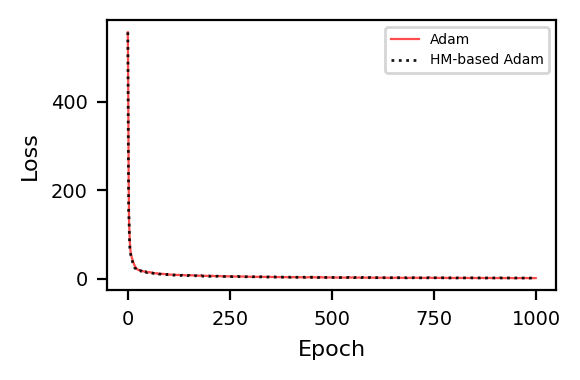

In [166]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['loss'] 
y2 = df2['loss']  
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('Loss' , fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xlabel('Epoch', fontdict = {'fontname':'Times New Roman', 'fontsize':8})
#plt.title("Loss", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 7, fontname = 'Times New Roman')
plt.yticks(fontsize = 7, fontname = 'Times New Roman')
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show()

MAE

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

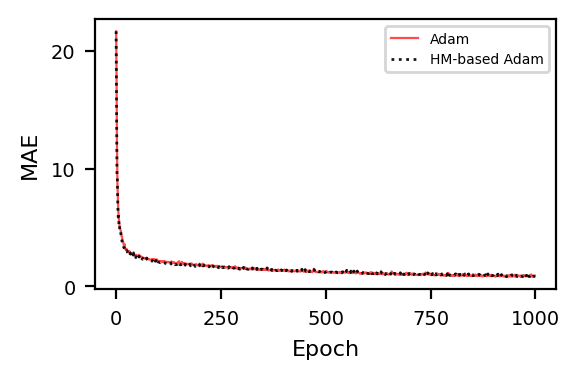

In [167]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['mae'] 
y2 = df2['mae']  
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('MAE' , fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xlabel('Epoch', fontdict = {'fontname':'Times New Roman', 'fontsize':8})
#plt.title("MAE", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 7, fontname = 'Times New Roman')
plt.yticks(fontsize = 7, fontname = 'Times New Roman')
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show()

#### Testing the model

Generic opimizer model

In [168]:
model_wihtout_hm.evaluate(X_test_normalized, y_test)

4/4 [==============================] - 0s 929us/step - loss: 23.0976 - mae: 3.2052


[23.097597122192383, 3.205240249633789]

HM based optimizer model

In [169]:
model_hm.evaluate(X_test_normalized, y_test)

4/4 [==============================] - 0s 1ms/step - loss: 17.1066 - mae: 2.8479


[17.106632232666016, 2.847865104675293]

#### Predicting for unseen input

In [170]:
input_data = np.array([0.63796, 0.00, 8.140, 0, 0.5380, 6.0960, 84.50, 4.4619, 4, 307.0, 21.00, 380.02, 10.26])
input_data_transformed = mms1.transform(input_data.reshape(1, -1))

Generic opimizer model

In [171]:
output = model_wihtout_hm.predict(input_data_transformed) 
output[0][0]

1/1 [==============================] - 0s 26ms/step


18.067787

HM based optimizer model

In [172]:
output = model_hm.predict(input_data_transformed) 
output[0][0]

1/1 [==============================] - 0s 25ms/step


18.719156